# Library

In [1]:
import requests
from bs4 import BeautifulSoup
from urllib.error import HTTPError

import http.client as httplib  # or http.client if you're on Python 3 # httplib
httplib._MAXHEADERS = 10000

import time
import datetime
from datetime import datetime, timedelta

import re
import gc

import json

import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
import sys

%matplotlib inline
import matplotlib.pyplot as plt

rus_mon_dict = {'янв': '01', 'фев': '02', 'мар': '03',
                'апр': '04', 'мая': '05', 'июн': '06',
                'июл': '07', 'авг': '08', 'сен': '09',
                'окт': '10', 'ноя': '11', 'дек': '12'}

## Folders & Files

In [2]:
# pathes
art_project_path = '/content/drive/MyDrive/Art/Art_Project'
art_project_path_backups = '/content/drive/MyDrive/Art/Art_Project/parsing_backups'
art_project_path_tests = '/content/drive/MyDrive/Art/Art_Project/parsing_tests'

# files
page_s = '/page_parsing_status.csv'

artinvest_s = '/artinvest_pages_counter_stat.csv'
artinvest_d = '/artinvest_news_articles_data.csv'
artinvest_lt = '/artinvest_long_text.csv'

theartnewspaper_d = '/theartnewspaper_data_new.csv'
theartnewspaper_lt = '/theartnewspaper_long_text.csv'

artchive_s = '/artchive_pages_counter_stat.csv'
artchive_d = '/artchive_news_articles_data.csv'
artchive_lt = '/artchive_long_text.csv'

artuzel_s = '/artusel_pages_counter_stat.csv'
artuzel_d = '/artuzel_news_articles_data.csv'
artuzel_lt = '/artuzel_long_text.csv'

## Sites' list for parsing

In [3]:
urls_news = ['https://www.theartnewspaper.ru/', 'https://artinvestment.ru/', 'http://artuzel.com/', 'https://artchive.ru/'] # 'https://artguide.com/', 'http://artuzel.com/', 
# https://artguide.com/ - <div class="chromeframe">
#    Ваш браузер <em>устарел!</em> <a href="http://browsehappy.com/">Установите другой браузер</a> или
#    <a href="http://www.google.com/chromeframe/?redirect=true">Google Chrome Frame</a>, чтобы просматривать этот сайт.
urls_datasets = ['https://artchive.ru/', 'https://artinvestment.ru/', 'http://artuzel.com/']
urls_archives = ['https://artchive.ru/', 'https://russianartarchive.net/ru'] # есть API - https://api.raan.garagemca.org/documentation/#/
urls_fairs = ['https://www.cosmoscow.com/ru/']

In [4]:
# topping up dict (manually yet)
#                             site,       s_file,        d_file,        lt_file
df_dict = {'https://www.theartnewspaper.ru/': ['-', theartnewspaper_d, theartnewspaper_lt], 
           'https://artinvestment.ru/': [artinvest_s, artinvest_d, artinvest_lt],
           'https://artchive.ru/': [artchive_s, artchive_d, artchive_lt],
           'https://artuzel.com/': [artuzel_s, artuzel_d, artuzel_lt]
           }

# Unused code

In [ ]:
# from requests.exceptions import MissingSchema

In [ ]:
# drop part of df
#artinvest_news_articles_data = artinvest_news_articles_data.drop(artinvest_news_articles_data[artinvest_news_articles_data['page_url']=='20220209_Hirst.html'].index)

In [ ]:
# delete all data from df
#artinvest_news_articles_data = artinvest_news_articles_data[0:0]
#theartnewspaper_data = theartnewspaper_data[0:0]

In [ ]:
#warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

# Functions
correct:
- fix labels in some graphics
- unify stat graf

## Openings and savings
1. __open_parsing_dict()__ -> parsing_dict - Open dict with sites for parsing
2. __open_file_csv(file, folder)__ -> df - Open file.csv
3. __save_df_file(df, file, folder)__ -> - Save df to csv file
4. __open_long_text_url_list_temp()__ -> parsing_list - Open json artinvest_long_text_url_list_temp
5. __save_long_text_url_list_temp(parsing_list)__ -> - Save json artinvest_long_text_url_list_temp

In [5]:
# 1. Open dict with sites for parsing
def open_parsing_dict():
  with open(art_project_path + '/sites_for_parsing.txt', 'rb') as infile:
    parsing_dict = json.load(infile)
  return parsing_dict

# 2. Open file.csv
def open_file_csv(file, folder): # folder: live, backup or test
  if folder=='live':
    df = pd.read_csv(art_project_path + file)
  elif folder=='backup':
    df = pd.read_csv(art_project_path_backups + file)
  elif folder=='test':
    df = pd.read_csv(art_project_path_tests + file)
  return df

# 3. Save df to csv file
def save_df_file(df, file, folder): # folder: live, backup or test
  if folder=='live':
    df.to_csv(art_project_path + file, index=False)
  elif folder=='backup':
    df.to_csv(art_project_path_backups + file, index=False)
  elif folder=='test':
    df.to_csv(art_project_path_tests + file, index=False)

# 4. Open json long_text_url_list_temp
def open_long_text_url_list_temp():
  with open(art_project_path + '/long_text_url_list_temp.txt', 'rb') as infile:
    parsing_list = json.load(infile)
  return parsing_list

# 5. Save json long_text_url_list_temp
def save_long_text_url_list_temp(parsing_list):
  with open(art_project_path + '/long_text_url_list_temp.txt', 'w') as outfile:
    json.dump(parsing_list, outfile)

## Data mining
6. __get_page(url)__ -> bs_page - Collect request status
7. __get_parsing_lists(site)__ -> links, titles - Get links & titles lists
8. Parsing pages_counter_stat:
- 8.1 __get_artinvest_pages_counter_stat(page_url, page, parsing_links, parsing_titles)__ -> df_counter_new - Parsing artinvest pages_counter_stat
9. Parsing current news_articles_data:
- 9.1 __get_artinvest_pages_curr_data(page_url, page, parsing_links, parsing_titles)__ -> df_data_new, long_text_url_list_new, print(message) - Parsing artinvest current news_articles_data
- 9.2 __get_tanp_pages_curr_data(page_url, page, parsing_links, parsing_titles)__ -> df_data_new, long_text_url_list_new, print(message) - Parsing tanp current news_articles_data
10. Parsing long texts:
- 10.1 __get_artinvest_long_text(text_page)__ -> long_text_list_new, sourses_list_new, parsing_speed_list_new - Parsing artinvest long texts
- 10.2 __get_tanp_long_text(text_page)__ -> long_text_list_new, sourses_list_new, parsing_speed_list_new - Parsing tanp long texts
11. Functions aggrigators:
- 11.1 __parsing_agg_sd(site, s_file, d_file, lt_file)__ -> print(message) - Getting pages_counter_stat, pages_curr_data csv files and json long_text_url_list_temp
- 11.2 __parsing_agg_lt(lt_file)__ -> print(message) - Getting long texts files
12. __long_text_problems_fix(lt_file, df)__ -> print(message) - Fixing long text problems
13. __get_news_articles_archive(s_file, d_file, lt_file, p_url)__ -> - Parsing news_articles_data ARCHIVE
14. __date_transfomation(cell)__ -> cell - Date transfomation
15. __get_stat_graphics()__ - Stat graphics
16. __get_articles_graphic(df)__ - Articles counting
17. __collect_lines_check(pages_counter_stat, news_articles_data)__ -> problem_archive_pages - Checking collected lines

### get_page

In [6]:
# 6. Collect request status - saving every get result

def get_page(url):
  start_time = time.time()

  response = requests.get(url, headers={'User-Agent': 'Chrome/97.0.4692.71'}) # timeout=0.001
# Edge/97.0.1072.55
# Chrome/97.0.4692.71
  try:
    response.raise_for_status()

  except requests.exceptions.HTTPError: # for correction
    sys.exit(print('HTTPError: ' + str(url)))

#except (HTTPError, MissingSchema): 
# 503 Server Error: Service Temporarily Unavailable for url: https://artinvestment.ru/news/artnews/ 
# Invalid URL

  else:
    get_page_stat_new = pd.DataFrame({'page_url': [url],
                                      'status_code': [response.status_code],
                                      'encoding': [response.encoding],
                                      'raise_for_status': [response.raise_for_status()],
                                      'parsing_date': [datetime.now().date()],
                                      'parsing_time': [datetime.now().time()],
                                      'parsing_sec_speed': [time.time() - start_time]})

    bs_page = BeautifulSoup(response.text, 'html.parser')
  
    get_page_stat = open_file_csv(page_s, 'live') # 2. Open file.csv
    get_page_stat = pd.concat([get_page_stat, get_page_stat_new])
    save_df_file(get_page_stat, page_s, 'live') # 3. Save df to csv file

    return bs_page

### get_parsing_lists

In [7]:
# 7. Get links & titles lists (site == url from sites' list for parsing)

def get_parsing_lists(site):
  sites = open_parsing_dict() # 1. Open dict with sites for parsing
  sites_list = [k for k in sites.keys()]
  cat_dict = ['news', 'articles'] # topping up list
  
  links = []
  titles = []

  for cat in cat_dict:
    for k in sites_list:
      if k==site:
        for i in sites[k]:
          if i==cat:
            links = list(links + sites[k][i]['links'])
            titles = list(titles + sites[k][i]['titles'])
  
  return links, titles

### get_pages_counter_stat

#### artinvestment.ru

In [8]:
# 8.1 Parsing artinvest pages_counter_stat - saving last parsing results from the first pages

def get_artinvest_pages_counter_stat(page_url, page, parsing_links, parsing_titles):
  start_time = time.time()

  # counter block of the page with news list - one for every news' category
  table_blocks = page.find_all('div', class_='pager')
  # problems can start from here
  global df_counter_new
  df_counter_new = pd.DataFrame({'page_url': [page_url],
                                 'page_title': [parsing_titles[parsing_links.index(page_url)]],
                                 'records_total': [int(table_blocks[0].find_all('em')[0].text)],
                                 'pages_total': [int(table_blocks[0].find_all('em')[1].text)],
                                 'records_max': [int(table_blocks[0].find('input').get('title').split(' ')[1])],
                                 'records_value': [int(table_blocks[0].find('input').get('value'))],
                                 'first_page_url': [table_blocks[0].find('a').get('href')],
                                 'parsing_date': [datetime.now().date()],
                                 'parsing_time': [datetime.now().time()],
                                 'parsing_sec_speed': [time.time() - start_time]
                                 })

  return df_counter_new

#### artchive.ru

In [9]:
# 8.2 Parsing artchive pages_counter_stat - saving last parsing results from the first pages

def get_artch_pages_counter_stat(page_url, page, parsing_links, parsing_titles):
  start_time = time.time()

  # counter block of the page with news list - one for every news' category
  table_blocks = page.find('div', class_='c_pager')
  pattern = re.compile('\d+')
  digits = []
  # problems can start from here
  try:
    for d in pattern.findall(table_blocks.find_all('script')[0].text):
      digits.append(int(d))
    for d in pattern.findall(table_blocks.find_all('script')[2].text):
      digits.append(int(d))
  except:
    digits = [np.nan, np.nan, np.nan, np.nan, np.nan]

  global df_counter_new
  df_counter_new = pd.DataFrame({'page_url': [page_url],
                                 'page_title': [parsing_titles[parsing_links.index(page_url)]],
                                 'records_total': [digits[3]],
                                 'pages_total': [digits[0]],
                                 'records_max': [digits[4]],
                                 'records_value': [np.nan],
                                 'first_page_url': [page_url],
                                 'parsing_date': [datetime.now().date()],
                                 'parsing_time': [datetime.now().time()],
                                 'parsing_sec_speed': [time.time() - start_time]
                                 })
  
  return df_counter_new

#### artuzel.com

In [10]:
# 8.3 Parsing artuzel pages_counter_stat - saving last parsing results from the first pages

def get_artuz_pages_counter_stat(page_url, page, parsing_links, parsing_titles):
  start_time = time.time()

  # counter block of the page with news list - one for every news' category
  table_blocks = page.find('li', class_='pager-current')
  digits = []
  # problems can start from here
  try:
    digits.append(int(table_blocks.get_text().split(' ')[0]))
    digits.append(int(table_blocks.get_text().split(' ')[2]))
  except:
    digits = [np.nan, np.nan]

  global df_counter_new
  df_counter_new = pd.DataFrame({'page_url': [page_url],
                                 'page_title': [parsing_titles[parsing_links.index(page_url)]],
                                 'records_total': [np.nan],
                                 'pages_total': [digits[1]],
                                 'records_max': [np.nan],
                                 'records_value': [np.nan],
                                 'first_page_url': [page_url],
                                 'parsing_date': [datetime.now().date()],
                                 'parsing_time': [datetime.now().time()],
                                 'parsing_sec_speed': [time.time() - start_time]
                                 })
  
  return df_counter_new

### get_pages_curr_data

#### artinvestment.ru

In [11]:
# 9.1 Parsing artinvest current news_articles_data - saving last parsing results from the first pages

def get_artinvest_pages_curr_data(page_url, page, parsing_links, parsing_titles):
  start_time = time.time()
  
  # News categories
  list_advices = page.find_all('ul', class_='list advices')
  # problems can start from here
  dates_list = []
  for em in list_advices[0].find_all('em'):
    dates_list.append(em.text)
  links_list = []
  titles_list = []
  for a in list_advices[0].find_all('a'):
    if re.compile('\d+').search(str(a.get('href')))is not None:
      links_list.append(a.get('href'))
    if a.get('title') is not None:
      titles_list.append(a.get('title'))
  short_text_list = []
  for span in list_advices[0].find_all('span')[1::2]:
    short_text_list.append(span.text)

  global df_data_new
  df_data_new = pd.DataFrame({'date': dates_list, # date of news
                              'link': links_list, # link to news
                              'title': titles_list, # title of news
                              'short_text': short_text_list, # news' preview
                              })
  df_data_new['page_url'] = page_url # link to category of news - the same
  df_data_new['page_title'] = parsing_titles[parsing_links.index(page_url)] # title of news' category - the same

  # For parsing long texts - beginning
  df_data_new['long_text_url'] = df_data_new['page_url'] + df_data_new['link']
  global long_text_url_list_new
  long_text_url_list_new = df_data_new['long_text_url'].tolist()

  df_data_new['parsing_date'] = datetime.now().date()
  df_data_new['parsing_time'] = datetime.now().time()
  df_data_new['parsing_sec_speed'] = time.time() - start_time # without long_text collection

  collected_pages_a_count = df_data_new['link'].count()

  return df_data_new, long_text_url_list_new, print('{} articles have been collected\nin {} seconds'.format(collected_pages_a_count, (time.time() - start_time)))

#### theartnewspaper.ru

In [12]:
# 9.2 Parsing tanp current news_articles_data - saving last parsing results from the first pages

def get_tanp_pages_curr_data(page_url, page, parsing_links, parsing_titles):
  start_time = time.time()
  
  # News categories
  links_list = []
  titles_list = []
  for prenews in page.find_all('div', class_='postPreviewsV2Root js-fix-post-previews'):
    # problems can start from here
    for a in prenews.find_all('a'):
      links_list.append(a.get('href'))
      titles_list.append(a.get('title'))
  dates_list = []
  for date in page.find_all('div', class_='postPreviewsItemDate'):
    # problems can start from here
    dates_list.append(date.get_text())
  page_title_list = []
  page_url_list = []
  for p_title in page.find_all('div', class_='postPreviewsItemSection'):
    # problems can start from here
    page_title_list.append(p_title.get_text())
    page_url_list.append(page_url)
  short_text_list = []
  for s_text in page.find_all('div', class_='postPreviewsItemTitle2 js-fix-hanging js-icon-read-more'):
    # problems can start from here
    short_text_list.append(s_text.get_text())

  global df_data_new
  df_data_new = pd.DataFrame({'date': dates_list, # date of news
                              'link': links_list, # link to news
                              'title': titles_list, # title of news
                              'short_text': short_text_list, # news' preview
                              'page_url': page_url_list, # link to category of news - the same
                              'page_title': page_title_list # title of news' category - not the same
                                             })
  
  # For parsing long texts - beginning
  df_data_new['long_text_url'] = df_data_new['page_url'].apply(lambda x: x.split('/')[0] + '//' + x.split('/')[2]) + df_data_new['link']
  global long_text_url_list_new
  long_text_url_list_new = df_data_new['long_text_url'].tolist()

  df_data_new['parsing_date'] = datetime.now().date()
  df_data_new['parsing_time'] = datetime.now().time()
  df_data_new['parsing_sec_speed'] = time.time() - start_time # without long_text collection

  collected_pages_a_count = df_data_new['link'].count()

  return df_data_new, long_text_url_list_new, print('{} articles have been collected\nin {} seconds'.format(collected_pages_a_count, (time.time() - start_time)))

#### artchive.ru

In [13]:
# 9.3 Parsing artchive current news_articles_data - saving last parsing results from the first pages

def get_artch_pages_curr_data(page_url, page, parsing_links, parsing_titles):
  start_time = time.time()
  
  # News categories
  items_block = page.find('div', class_='knowledge-list').find_all('div', class_='item')
  
  links_list = []
  titles_list = []
  short_text_list = []
  for item in items_block:
    # problems can start from here
    links_list.append(item.find('div', class_='item-announce').find('a').get('href'))
    titles_list.append(item.find('div', class_='item-announce').find('a').get_text())
    short_text_list.append(item.find('div', class_='item-announce').find('a').get_text())
  dates_list = []
  for date in items_block:
    # problems can start from here
    try:
      dates_list.append(pd.to_datetime(date.find('div', class_='item-date').find('time').get('datetime')).date())
    except: 
      dates_list.append(datetime.now().date())
  page_title_list = []
  page_url_list = []
  for tag in items_block:
    page_url_list.append(page_url)
    try:
      page_title_list.append(tag.find('div', class_='item-tags').find_all('a')[0].get_text())
    except:
      page_title_list.append(parsing_titles[parsing_links.index(page_url)])

  global df_data_new
  df_data_new = pd.DataFrame({'date': dates_list, # date of news
                              'link': links_list, # link to news
                              'title': titles_list, # title of news
                              'short_text': short_text_list, # news' preview
                              'page_url': page_url_list, # link to category of news - the same
                              'page_title': page_title_list # title of news' category - not the same
                              })
  
  # For parsing long texts - beginning
  df_data_new['long_text_url'] = df_data_new['page_url'].apply(lambda x: x.split('/')[0] + '//' + x.split('/')[2]) + df_data_new['link']
  global long_text_url_list_new
  long_text_url_list_new = df_data_new['long_text_url'].tolist()

  df_data_new['parsing_date'] = datetime.now().date()
  df_data_new['parsing_time'] = datetime.now().time()
  df_data_new['parsing_sec_speed'] = time.time() - start_time # without long_text collection

  collected_pages_a_count = df_data_new['link'].count()

  return df_data_new, long_text_url_list_new, print('{} articles have been collected\nin {} seconds'.format(collected_pages_a_count, (time.time() - start_time)))

#### artuzel.com

In [14]:
# 9.4 Parsing artuzel current news_articles_data - saving last parsing results from the first pages

def get_artuz_pages_curr_data(page_url, page, parsing_links, parsing_titles):
  start_time = time.time()
  
  # News categories
  items_block = page.find_all('div', class_='view-content')[0].find_all('a')
  
  links_list = []
  titles_list = []
  short_text_list = []
  for item in items_block[:20]: # very few sections have pages (20 articles on each), the others contain all articles accumulatively !!!
  #for item in items_block: # !!! only for collecting the ARCHIVE !!!
    # problems can start from here
    links_list.append(item.get('href'))
    titles_list.append(item.find('div', class_='view-exhibitions-title').get_text())
    short_text_list.append(item.find('div', class_='view-exhibitions-body').get_text())
  dates_list = []
  for date in items_block[:20]: # very few sections have pages (20 articles on each), the others contain all articles accumulatively !!!
  #for date in items_block: # !!! only for collecting the ARCHIVE !!!
    # problems can start from here
    try:
      d = date.find('div', class_='views-field-field-created').get_text().split(',')[1]
      dates_list.append(d.split(' ')[1] + '.' + rus_mon_dict[d.split(' ')[2][:3]] + '.' + d.split(' ')[3])
    except:
      try:
        d = date.find('span', class_='date-display-single').get_text().split(',')[1]
        dates_list.append(d.split(' ')[1] + '.' + rus_mon_dict[d.split(' ')[2][:3]] + '.' + d.split(' ')[3])
      except: 
        dates_list.append(datetime.now().date())

  global df_data_new
  df_data_new = pd.DataFrame({'date': dates_list, # date of news
                              'link': links_list, # link to news
                              'title': titles_list, # title of news
                              'short_text': short_text_list # news' preview
                              })
  df_data_new['page_url'] = page_url # link to category of news - the same
  df_data_new['page_title'] = parsing_titles[parsing_links.index(page_url)] # title of news' category - the same

  
  # For parsing long texts - beginning
  df_data_new['long_text_url'] = df_data_new['page_url'].apply(lambda x: x.split('/')[0] + '//' + x.split('/')[2]) + df_data_new['link']
  global long_text_url_list_new
  long_text_url_list_new = df_data_new['long_text_url'].tolist()

  df_data_new['parsing_date'] = datetime.now().date()
  df_data_new['parsing_time'] = datetime.now().time()
  df_data_new['parsing_sec_speed'] = time.time() - start_time # without long_text collection

  collected_pages_a_count = df_data_new['link'].count()

  return df_data_new, long_text_url_list_new, print('{} articles have been collected\nin {} seconds'.format(collected_pages_a_count, (time.time() - start_time)))

### get_long_text

#### artinvestment.ru

In [15]:
# 10.1 Parsing artinvest long texts - saving only new results from the first pages
    
def get_artinvest_long_text(text_page):
  start_time = time.time()

  p_block = text_page.find('div', class_='block white').find_all('p')
  f_block = text_page.find('div', class_='block white').find_all('figure')
  sp_block = text_page.find('div', class_='block white').find_all('span')

  global long_text_list_new
  long_text_list_new = []
  global headings_list_new
  headings_list_new = []
  try:
    long_text_list_new.append(text_page.find('div', class_='block white').find('h1').get_text())
    headings_list_new.append(text_page.find('div', class_='block white').find('h1').get_text())
    for p in p_block:
      long_text_list_new.append(p.text) # the whole text
      try:
        for a in p.find_all('a'):
          if a not in headings_list_new:
            headings_list_new.append(a.get_text()) # links' title
      except: continue
      try:
        for s in p.find_all('strong'):
          if s not in headings_list_new:
            headings_list_new.append(s.get_text()) # bold text
      except: continue
  except: pass

  global images_list_new
  images_list_new = []
  try:
    try:
      for sp in sp_block:
        images_list_new.append(sp.find('img').get('src'))
        images_list_new.append(sp.text)
    except:
      for f in f_block:
        images_list_new.append(f.find('img').get('src'))
        images_list_new.append(f.find('a').get('title'))
  except: pass

  global sourses_list_new
  sourses_list_new = []
  try:
    for t in text_page.find('div', class_='block content-data article-content').find('p', class_='mat2left').find_all('a'):
      sourses_list_new.append(t.get('href'))
  except: pass

  global tags_list_new
  tags_list_new = []
  
  global parsing_speed_list_new
  parsing_speed_list_new = [(time.time() - start_time)]

  return long_text_list_new, headings_list_new, images_list_new, sourses_list_new, tags_list_new, parsing_speed_list_new

#### theartnewspaper.ru

In [16]:
# 10.2 Parsing tanp long texts - saving only new results from the first pages
    
def get_tanp_long_text(text_page):
  start_time = time.time()

  t_block = text_page.find_all('div', class_='leftCol630')
  img_block = text_page.find_all('div', class_='leftCol')[4].find_all('img') # !!!
  tag_block = text_page.find('div', class_='postSectionsRoot').find_all('a')

  # new part
  global tags_list_new
  tags_list_new = []
  try:
    for tag in tag_block:
      tags_list_new.append(tag.get('href'))
      tags_list_new.append(tag.get_text())
  except: pass

  # different code
  global long_text_list_new
  long_text_list_new = []
  global headings_list_new
  headings_list_new = []
  # 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'div' class_='postListItemTitleRoot', 'b', 'blockquote'
  try:
    for t in t_block:
      long_text_list_new.append(t.get_text())
      for h in ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']:
        h_block = t.find_all(h)
        try:
          for h_str in h_block:
            if h_str not in headings_list_new:
              headings_list_new.append(h_str.get_text())
        except: continue
      div_block = t.find_all('div', class_='postListItemTitleRoot')
      try:
        for d_str in div_block:
          if d_str not in headings_list_new:
            headings_list_new.append(d_str.get_text())
      except: pass
      for b in ['b', 'blockquote']:
        b_block = t.find_all(b)
        try:
          for b_str in b_block:
            if b_str not in headings_list_new:
              headings_list_new.append(b_str.get_text())
        except: continue
  except: pass

  global images_list_new
  images_list_new = []
  try:
    for img in img_block:
      if len(img.get('alt')) != 0:
        images_list_new.append(img.get('src'))
        images_list_new.append(img.get('alt'))
  except: pass

  global sourses_list_new
  sourses_list_new = []
  global parsing_speed_list_new
  parsing_speed_list_new = [(time.time() - start_time)]

  return long_text_list_new, headings_list_new, images_list_new, sourses_list_new, tags_list_new, parsing_speed_list_new

#### artchive.ru

In [17]:
# 10.3 Parsing artch long texts - saving only new results from the first pages
    
def get_artch_long_text(text_page):
  start_time = time.time()

  t_block = text_page.find('div', class_='article').find_all('div', class_='text-block')
  st_block = text_page.find('div', class_='article').find_all('div', class_='strong-text')
  img_block = text_page.find('div', class_='article').find_all('div', class_='c_img ')
  tag_block = text_page.find('div', class_='article').find('div', 'content-footer__tags')

  # different code
  global tags_list_new
  tags_list_new = []
  try:
    for tag in tag_block.find_all('a'):
      tags_list_new.append(tag.get('href'))
      tags_list_new.append(tag.get_text()[1:])
  except: pass

  global long_text_list_new
  long_text_list_new = []
  global headings_list_new
  headings_list_new = [] # 'Читать дальше\n' !!!!!!!!!!!!!!
  # 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'div' class_='postListItemTitleRoot', 'b', 'blockquote'
  try:
    long_text_list_new.append(text_page.find('div', class_='article').find('h1').get_text())
    headings_list_new.append(text_page.find('div', class_='article').find('h1').get_text())
    for t in t_block:
      add_news = t.find('div', class_='news-link')
      try:
        len(add_news.get_text())
      except:
        long_text_list_new.append(t.get_text())
        for h in ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']:
          h_block = t.find_all(h)
          try:
            for h_str in h_block:
              if h_str not in headings_list_new:
                headings_list_new.append(h_str.get_text())
          except: continue
        a_block = t.find_all('a')
        try:
          for a_str in a_block:
            if a_str not in headings_list_new:
              headings_list_new.append(a_str.get_text())
        except: pass
        for b in ['b', 'blockquote']:
          b_block = t.find_all(b)
          try:
            for b_str in b_block:
              if b_str not in headings_list_new:
                headings_list_new.append(b_str.get_text())
          except: continue
          try:
            for st in st_block:
              if st not in headings_list_new:
              #long_text_list_new.append(st.get_text()) # because of sourse
                headings_list_new.append(st.get_text())
          except: pass
  except: pass

  l='Читать дальше\n' # don't work correctly
  for el in headings_list_new:
    if el==l:
      headings_list_new.remove(el)

  global images_list_new
  images_list_new = []
  # title can be not full
  # don't collect 'post-art test-two-arts' divs
  try:
    for img in img_block:
      images_list_new.append(img.find('img').get('src'))
      images_list_new.append(img.find('img').get('title'))
  except: pass

  global sourses_list_new
  sourses_list_new = []
  pattern = re.compile('По материалам ')
  string = long_text_list_new[-1].replace('\xa0', ' ')
  if type(pattern.match(string)) is re.Match:
    sourses_list_new.append(string.replace('По материалам ', ''))
  
  global parsing_speed_list_new
  parsing_speed_list_new = [(time.time() - start_time)]

  return long_text_list_new, headings_list_new, images_list_new, sourses_list_new, tags_list_new, parsing_speed_list_new

#### artuzel.com

In [18]:
# 10.4 Parsing artuzel long texts - saving only new results from the first pages
    
def get_artuz_long_text(text_page):
  start_time = time.time()

  t_block = text_page.find('div', class_='content clearfix').find_all('p')
  img_block = text_page.find('div', class_='content clearfix').find_all('img')
  tag_block = text_page.find('ul', class_='links inline')

  # different code
  global tags_list_new
  tags_list_new = []
  try:
    for tag in tag_block.find_all('a'):
      tags_list_new.append(tag.get('href'))
      tags_list_new.append(tag.get_text())
  except: pass

  global long_text_list_new
  long_text_list_new = []
  global headings_list_new
  headings_list_new = []
  # date of the news - for replacing in current data
  # new part
  d = text_page.find('div', class_='meta submitted').get_text().split(',')[1]
  headings_list_new.append(d.split(' ')[1] + '.' + rus_mon_dict[d.split(' ')[2][:3]] + '.' + d.split(' ')[3])
  
  # 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'div' class_='postListItemTitleRoot', 'b', 'blockquote'
  try:
    long_text_list_new.append(text_page.find('h1', id='page-title').get_text())
    headings_list_new.append(text_page.find('h1', id='page-title').get_text())
    for t in t_block:
      long_text_list_new.append(t.get_text())
      for h in ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']:
        h_block = t.find_all(h)
        try:
          for h_str in h_block:
            if h_str not in headings_list_new:
              headings_list_new.append(h_str.get_text())
        except: continue
      for b in ['strong', 'span', 'em', 'b']:
        b_block = t.find_all(b)
        try:
          for b_str in b_block:
            if b_str not in headings_list_new:
              headings_list_new.append(b_str.get_text())
        except: continue

  except: pass

  global images_list_new
  images_list_new = []
  # title can be not full
  try:
    for img in img_block:
      images_list_new.append(img.get('src'))
      try:
        images_list_new.append(img.get('title'))
      except:
        images_list_new.append('')
  except: pass

  global sourses_list_new
  sourses_list_new = []
  global parsing_speed_list_new
  parsing_speed_list_new = [(time.time() - start_time)]

  return long_text_list_new, headings_list_new, images_list_new, sourses_list_new, tags_list_new, parsing_speed_list_new

### news_articles_data ARCHIVE

#### artinvest.ru

In [19]:
# 13.1 Parsing artinvest news_articles_data ARCHIVE
def get_artinvest_next_page_url_list(first_page_url, pages_total):

  url_part_1 = first_page_url.split('=')[0]
  url_part_2 = first_page_url.split('=')[1].split('&')[1]
  url_part_3 = first_page_url.split('=')[2]

  global next_page_url_list_new
  next_page_url_list_new = []
  for p in range(2, pages_total+1):
    next_page_url = url_part_1 + '=' + str(p) + '&' + url_part_2 + '=' + url_part_3
    next_page_url_list_new.append(next_page_url)

  return next_page_url_list_new

#### artchive.ru

In [20]:
# 13.2 Parsing artchive news_articles_data ARCHIVE
def get_artch_next_page_url_list(first_page_url, pages_total):

  global next_page_url_list_new
  next_page_url_list_new = []
  for p in range(2, pages_total+1):
    url_split = first_page_url.split('/')
    try:
      if first_page_url.split('/')[4][:6]=='rubric':
        next_page_url = url_split[0]+'//'+url_split[2]+'/'+url_split[3]+'/p:'+str(p)+'-'+url_split[4]
      else:
        next_page_url = first_page_url + '/p:' + str(p)
    except:
      next_page_url = first_page_url + '/p:' + str(p)

    next_page_url_list_new.append(next_page_url)

  return next_page_url_list_new

#### artuzel.com

In [21]:
# 13.3 Parsing artuzel news_articles_data ARCHIVE
def get_artuz_next_page_url_list(first_page_url, pages_total):

  global next_page_url_list_new
  next_page_url_list_new = []

  if pages_total > 1.0:
    for p in range(1, int(pages_total)):
      url_split = first_page_url.split('/')
      next_page_url = url_split[0]+'//'+url_split[2]+'/'+url_split[3]+'?page='+str(p)
      next_page_url_list_new.append(next_page_url)
  else:
    next_page_url_list_new.append(first_page_url)

  return next_page_url_list_new

### Functions aggrigators

#### parsing_agg_sd()

In [22]:
#### Step 1
# 11.1 Getting pages_counter_stat, pages_curr_data csv files and json long_text_url_list_temp

def parsing_agg_sd(site, s_file, d_file, lt_file):

  parsing_links_list, parsing_titles_list = get_parsing_lists(site) # 7. Get links & titles
                                           #get_parsing_lists(site)

  try:
    df_counter = open_file_csv(s_file, 'live') # 2. Open file.csv
    df_counter['parsing_date'] = df_counter['parsing_date'].dropna().apply(lambda x: date_transfomation(x)) # 14. Date transfomation
  except: pass

  df_data = open_file_csv(d_file, 'live') # 2. Open file.csv
  df_data['parsing_date'] = df_data['parsing_date'].dropna().apply(lambda x: date_transfomation(x)) # 14. Date transfomation
  
  # For parsing long texts
  long_text_url_list = []

  for link in parsing_links_list: # page with news list of certain category
    link_page = get_page(link) # 1. Collect request status

    # for artinvestment.ru
    if d_file == artinvest_d:

      # counter block of the page with news list - one for every news' category
      # 8.1 Parsing artinvest pages_counter_stat
      get_artinvest_pages_counter_stat(link, link_page, parsing_links_list, parsing_titles_list)
      df_counter = pd.concat([df_counter, df_counter_new]) # + one line to the df

      # 9.1 Parsing artinvest current news_articles_data
      get_artinvest_pages_curr_data(link, link_page, parsing_links_list, parsing_titles_list)
      
      df_data = pd.concat([df_data, df_data_new])
      long_text_url_list = list(long_text_url_list + long_text_url_list_new)

    # for theartnewspaper.ru
    elif d_file == theartnewspaper_d:

      # 9.2 Parsing tanp current news_articles_data
      get_tanp_pages_curr_data(link, link_page, parsing_links_list, parsing_titles_list)
      
      df_data = pd.concat([df_data, df_data_new])
      long_text_url_list = list(long_text_url_list + long_text_url_list_new)

    # for artchive.ru
    elif d_file == artchive_d:

      # 8.2 Parsing artchive pages_counter_stat
      get_artch_pages_counter_stat(link, link_page, parsing_links_list, parsing_titles_list)
      df_counter = pd.concat([df_counter, df_counter_new]) # + one line to the df

      # 9.3 Parsing artch current news_articles_data
      get_artch_pages_curr_data(link, link_page, parsing_links_list, parsing_titles_list)
      
      df_data = pd.concat([df_data, df_data_new])
      long_text_url_list = list(long_text_url_list + long_text_url_list_new)

    # for artuzel.com
    elif d_file == artuzel_d:

      # 8.3 Parsing artuzel pages_counter_stat
      get_artuz_pages_counter_stat(link, link_page, parsing_links_list, parsing_titles_list)
      df_counter = pd.concat([df_counter, df_counter_new]) # + one line to the df

      # 9.4 Parsing artuzel current news_articles_data
      get_artuz_pages_curr_data(link, link_page, parsing_links_list, parsing_titles_list)
      
      df_data = pd.concat([df_data, df_data_new])
      long_text_url_list = list(long_text_url_list + long_text_url_list_new)

    #### loop ending

  try:
    df_counter.drop_duplicates(subset = ['page_url', 'parsing_date'], keep = 'last', inplace = True)
    save_df_file(df_counter, s_file, 'live') # 3. Save df to csv file
    df_counter['site'] = df_counter['page_url'].apply(lambda x: x.split('/')[0] + '//' + x.split('/')[2] + '/')
    new_pages_count = df_counter.loc[(df_counter['parsing_date']==datetime.now().date())&(df_counter['site']==site)]['page_url'].count()

    result = '{} new counter blocks have been collected\nAll counter blocks have been collected - {}'.format(new_pages_count, (new_pages_count==len(parsing_links_list)))

  except:
    result = 'No counter block exists'

  # For parsing long texts - continueing
  save_long_text_url_list_temp(long_text_url_list) # 5. Save json long_text_url_list_temp

  df_data.drop_duplicates(subset = 'long_text_url', keep = 'first', inplace = True) # was keep = 'last' before
  save_df_file(df_data, d_file, 'live') # 3. Save df to csv file

  time.sleep(5) # time for renewing json artinvest_long_text_url_list_temp
  parsing_agg_lt(lt_file) # 11.2 Getting long texts files
    
  return print(result)

#### parsing_agg_lt()

In [23]:
#### Step 2
# 11.2 Getting long texts files

def parsing_agg_lt(lt_file):

  long_text_df = open_file_csv(lt_file, 'live') # 2. Open file.csv
  long_text_url_list_old = long_text_df['long_text_url'].tolist()
  long_text_url_list_temp = open_long_text_url_list_temp() # 4. Open json long_text_url_list_temp
  long_text_url_list_curr = list(set(long_text_url_list_temp) - set(long_text_url_list_old)) # only new urls - temporal list

  long_text_list = []
  headings_list = []
  images_list = []
  sourses_list = []
  tags_list = []
  parsing_speed_list = []

  for url in long_text_url_list_curr: # one article from certane category news list
    page = get_page(url) # 1. Collect request status

    # for artinvestment.ru
    if lt_file == artinvest_lt:
      get_artinvest_long_text(page) # 10.1 Parsing artinvest long texts
     
    # for theartnewspaper.ru
    elif lt_file == theartnewspaper_lt:
      get_tanp_long_text(page) # 10.2 Parsing theartnewspaper long texts

    # for artchive.ru
    elif lt_file == artchive_lt:
      get_artch_long_text(page) # 10.3 Parsing artchive long texts

    # for artuzel.com
    elif lt_file == artuzel_lt:
      get_artuz_long_text(page) # 10.4 Parsing artuzel long texts

    long_text_list.append(long_text_list_new)
    headings_list.append(headings_list_new)
    images_list.append(images_list_new)
    sourses_list.append(sourses_list_new)
    tags_list.append(tags_list_new)
    parsing_speed_list.append(parsing_speed_list_new)

  #### loop ending

  long_text_df_new = pd.DataFrame({'long_text_url': long_text_url_list_curr,
                                   'long_text': long_text_list,
                                   'structure': headings_list,
                                   'images': images_list,
                                   'sourses': sourses_list,
                                   'tags': tags_list,
                                   'parsing_sec_speed_2': parsing_speed_list # for long_text collection without getting page
                                   })
  
  collected_pages_t_count = long_text_df_new['long_text_url'].count()
  long_text_df = pd.concat([long_text_df, long_text_df_new])
  long_text_df.drop_duplicates(subset = 'long_text_url', keep = 'first', inplace = True)

  save_df_file(long_text_df, lt_file, 'live') # 3. Save df to csv file

  return print('{} text pages have been collected\nAll text pages have been collected - {}'.format(collected_pages_t_count, collected_pages_t_count==len(long_text_url_list_curr)))

#### parsing_agg_a_n_archive

In [24]:
# 11.3 Parsing news_articles_data ARCHIVE - particular category separately (p_url) after checking, last parsing

def parsing_agg_a_n_archive(s_file, d_file, lt_file, p_url):
  df_counter_arch = open_file_csv(s_file, 'live') # 2. Open file.csv - counter_stat
  df_counter_arch['parsing_date'] = df_counter_arch['parsing_date'].dropna().apply(lambda x: date_transfomation(x)) # 14. Date transfomation
  df_counter_arch = df_counter_arch.loc[(df_counter_arch['page_url']==p_url)&(df_counter_arch['parsing_date']==df_counter_arch['parsing_date'].max())]

  df_data = open_file_csv(d_file, 'live') # 2. Open file.csv - current data
  df_data['parsing_date'] = df_data['parsing_date'].dropna().apply(lambda x: date_transfomation(x)) # 14. Date transfomation

  # For parsing current artinvest_news_articles_data
  pars_links_list = df_counter_arch['page_url'].tolist()
  pars_titles_list = df_counter_arch['page_title'].tolist()
  # For next_page_url_list
  first_page_url = df_counter_arch['first_page_url'].unique()[0]
  pages_total = df_counter_arch['pages_total'].unique()[0]

  next_page_url_list = []

  # for artinvestment.ru
  if d_file == artinvest_d:
    # 13.1 Parsing artinvest news_articles_data ARCHIVE
    get_artinvest_next_page_url_list(first_page_url, pages_total)
    next_page_url_list = list(next_page_url_list + next_page_url_list_new)
  
  # for artchive.ru
  elif d_file == artchive_d:
    # 13.2 Parsing artchive news_articles_data ARCHIVE
    get_artch_next_page_url_list(first_page_url, pages_total)
    next_page_url_list = list(next_page_url_list + next_page_url_list_new)

  # for artuzel.com
  elif d_file == artuzel_d:
    # 13.3 Parsing artuzel news_articles_data ARCHIVE
    get_artuz_next_page_url_list(first_page_url, pages_total)
    next_page_url_list = list(next_page_url_list + next_page_url_list_new)

  #### loop ending

  # For parsing long texts
  long_text_url_list = []

  for np_url in next_page_url_list:
    try:
      page = get_page(np_url) # 1. Collect request status

      # for artinvestment.ru
      if d_file == artinvest_d:   
        # 9.1 Parsing artinvestment current news_articles_data
        get_artinvest_pages_curr_data(p_url, page, pars_links_list, pars_titles_list)
      
        df_data = pd.concat([df_data, df_data_new])
        long_text_url_list = list(long_text_url_list + long_text_url_list_new)
    
      # for artchive.ru
      elif d_file == artchive_d:
        # 9.3 Parsing artchive current news_articles_data
        get_artch_pages_curr_data(p_url, page, pars_links_list, pars_titles_list)
      
        df_data = pd.concat([df_data, df_data_new])
        long_text_url_list = list(long_text_url_list + long_text_url_list_new)

      # for artuzel.com
      elif d_file == artuzel_d:
        # 9.4 Parsing artuzel current news_articles_data
        get_artuz_pages_curr_data(p_url, page, pars_links_list, pars_titles_list)
      
        df_data = pd.concat([df_data, df_data_new])
        long_text_url_list = list(long_text_url_list + long_text_url_list_new)
    
    except: continue
    #### loop ending

  # For parsing long texts - continueing
  save_long_text_url_list_temp(long_text_url_list) # 5. Save json long_text_url_list_temp

  df_data.drop_duplicates(subset = 'long_text_url', keep = 'first', inplace = True) # was keep = 'last' before
  save_df_file(df_data, d_file, 'live') # 3. Save df to csv file

  time.sleep(5) # time for renewing json artinvest_long_text_url_list_temp
  parsing_agg_lt(lt_file) # 11.2 Getting long texts files

### long_text_problems_fix

In [25]:
# 12. Fixing long text problems

def long_text_problems_fix(lt_file, df):
  cheking_long_text_list = []
  # Step 1
  for url in df.loc[df['long_text'].isna()==True]['long_text_url']:
    cheking_long_text_list.append(url)
  # Step 2
  df = df.loc[df['long_text'].isna()==False]
  df['long_text_len'] = df['long_text'].apply(lambda x: len(x[1:-1]))
  for url in df.loc[df['long_text_len']==0]['long_text_url']:
    cheking_long_text_list.append(url)
  #del copy_df
  #gc.collect()

  delta = len(cheking_long_text_list)

  if delta == 0:
    result = 'All long texts were found'
  else:
    long_text_url_visited = len(page_statistic.loc[page_statistic['page_url'].isin(cheking_long_text_list)]['page_url'].unique().tolist())

    result = 'Long texts delta is - {}\nCount of sites were visited - {}'.format(delta, long_text_url_visited)

    save_long_text_url_list_temp(cheking_long_text_list) # 5. Save json long_text_url_list_temp
    time.sleep(5) # time for renewing json artinvest_long_text_url_list_temp
      
    parsing_agg_lt(lt_file) # 11.2 Getting long texts files
  
  return print(result)

### collect_lines_check

In [26]:
# 17. Checking collected lines
def collect_lines_check(pages_counter_stat, news_articles_data):

  pages_counter = pages_counter_stat.loc[pages_counter_stat['parsing_date']==pages_counter_stat['parsing_date'].max()][['page_url', 'page_title', 'pages_total', 'records_total']]
  data_counter = news_articles_data.groupby(['page_title']).size().to_frame(name = 'count').reset_index()
  global combo
  combo = pages_counter.merge(data_counter, on='page_title', how='outer')
  combo['delta'] = combo['records_total'] - combo['count']

  global problem_archive_pages
  problem_archive_pages = combo.loc[combo['delta']!=0]['page_url'].tolist()
  if len(problem_archive_pages)==0:
    print('Records delta has not found')
  else:
    display(combo.loc[combo['page_url'].isin(problem_archive_pages)])

### date_transfomation

In [27]:
# 14. Date transfomation
def date_transfomation(cell):
  try:
    cell = pd.to_datetime(datetime.strptime(cell, '%d.%m.%Y').strftime('%Y-%m-%d')).date()
  except ValueError:
    cell = pd.to_datetime(cell).date()
  return cell

## Graphics
15. get_graphics() -> - Drawing graphics

In [28]:
# !!!!!!!!!!!!!!!!! for unification
# 15. Drawing graphics

def get_stat_graphics():
  # 15.1 Checking responses status
  print('Checking responses status & Parsing date')
  print('')
  new_stat = page_statistic.loc[page_statistic['parsing_date'] >= (page_statistic['parsing_date'].max() + timedelta(days = -7))]
  
  fig, axes = plt.subplots(1, 2, figsize=(12,4))
  
  axes[0].hist(page_statistic['status_code'])
  axes[0].set_title('Status code')
  axes[0].set_ylabel('Count')
  #axes[0].set_xticklabels(page_statistic['status_code'].unique(), rotation = 45)
  
  axes[1].hist(new_stat['parsing_date'])
  axes[1].set_title('Parsing date counts')
  axes[1].set_ylabel('Count')
  axes[1].set_xticklabels(new_stat['parsing_date'].unique(), rotation = 45)

  plt.show()

  # 15.2 Collecting Pages counter mining avarege speed
  print('')
  print('Collecting Pages counter mining avarege speed')
  print('')
  grouped_page_stat = page_statistic.groupby(['parsing_date', 'page_url'])['parsing_sec_speed'].agg(['mean']).reset_index()

  pages_counter_mining = pd.merge(artinvest_pages_counter_stat, grouped_page_stat, on=['parsing_date', 'page_url'], how='left')
  pages_counter_mining.columns = ['page_url', 'page_title', 'records_total', 'pages_total', 'records_max', 'records_value',
                                  'first_page_url', 'parsing_date', 'parsing_time', 'parsing_counter_speed', 'parsing_page_speed']
  pages_counter_mining['parsing_speed_total'] = pages_counter_mining['parsing_counter_speed'] + pages_counter_mining['parsing_page_speed']

  pages_counter_mining = pages_counter_mining.loc[pages_counter_mining['parsing_date'] >= (pages_counter_mining['parsing_date'].max() + timedelta(days = -7))]
  pages_counter_mining = pages_counter_mining.groupby(['parsing_date'])[['parsing_speed_total', 'parsing_page_speed', 'parsing_counter_speed']].mean().reset_index()

  fig, axes = plt.subplots(1, 3, figsize=(12,4))
  axes[0].bar(x=pages_counter_mining['parsing_date'], height=pages_counter_mining['parsing_speed_total'], color='red')
  axes[0].set_xticklabels(pages_counter_mining['parsing_date'], rotation = 90)
  axes[0].set_title('Total avg speed in seconds')

  axes[1].bar(x=pages_counter_mining['parsing_date'], height=pages_counter_mining['parsing_page_speed'], color='blue')
  axes[1].set_xticklabels(pages_counter_mining['parsing_date'], rotation = 90)
  axes[1].set_title('Page avg speed in seconds')

  axes[2].bar(x=pages_counter_mining['parsing_date'], height=pages_counter_mining['parsing_counter_speed'], color='green')
  axes[2].set_xticklabels(pages_counter_mining['parsing_date'], rotation = 90)
  axes[2].set_title('Counter avg speed in seconds')

  plt.show()

  # 15.3 Collecting Data mining avarege speed
  print('')
  print('Collecting Data mining avarege speed')
  print('')
  grouped_news_articl_stat = artinvest_news_articles_w_text.groupby(['parsing_date', 'page_url'])['parsing_sec_speed', 'parsing_sec_speed_2'].agg(['mean']).reset_index()
  grouped_news_articl_stat.columns = ['parsing_date',	'page_url',	'parsing_data_speed',	'parsing_text_speed']

  pages_data_mining = pd.merge(grouped_news_articl_stat, grouped_page_stat, on=['parsing_date', 'page_url'], how='left')
  pages_data_mining.columns = ['parsing_date', 'page_url', 'parsing_data_speed', 'parsing_text_speed', 'parsing_page_speed']

  pages_data_mining['parsing_speed_total'] = pages_data_mining['parsing_data_speed'] + pages_data_mining['parsing_text_speed'] + pages_data_mining['parsing_page_speed']

  pages_data_mining = pages_data_mining.loc[pages_data_mining['parsing_date'] >= (pages_data_mining['parsing_date'].max() + timedelta(days = -7))]
  pages_data_mining = pages_data_mining.groupby(['parsing_date'])[['parsing_data_speed', 'parsing_text_speed', 'parsing_page_speed', 'parsing_speed_total']].mean().reset_index()

  fig, axes = plt.subplots(1, 4, figsize=(12,4))
  axes[0].bar(x=pages_data_mining['parsing_date'], height=pages_data_mining['parsing_speed_total'], color='red')
  axes[0].set_xticklabels(pages_data_mining['parsing_date'], rotation = 90)
  axes[0].set_title('Total avg speed in seconds')

  axes[1].bar(x=pages_data_mining['parsing_date'], height=pages_data_mining['parsing_page_speed'], color='blue')
  axes[1].set_xticklabels(pages_data_mining['parsing_date'], rotation = 90)
  axes[1].set_title('Page avg speed in seconds')

  axes[2].bar(x=pages_data_mining['parsing_date'], height=pages_data_mining['parsing_data_speed'], color='green')
  axes[2].set_xticklabels(pages_data_mining['parsing_date'], rotation = 90)
  axes[2].set_title('Data avg speed in seconds')

  axes[3].bar(x=pages_data_mining['parsing_date'], height=pages_data_mining['parsing_text_speed'], color='orange')
  axes[3].set_xticklabels(pages_data_mining['parsing_date'], rotation = 90)
  axes[3].set_title('Text avg speed in seconds')

  plt.show()

In [29]:
# 16. Articles counting
def get_articles_graphic(df):
  # today for previouse day or for some days ago
  new_data = df.loc[df['date']>=df['parsing_date'].unique()[1]]

  print('Articles counting')
  print('')
  
  fig = plt.figure()
  axes = fig.add_axes([0,0,1,1])
  axes.hist(new_data['page_title'])
  axes.set_title('New articles')
  axes.set_ylabel('Count')
  axes.set_xticklabels(new_data['page_title'].unique(), rotation = 20)

  plt.show()

  print('')
  print('New articles titles (sience previous parsing date):')
  print('')
  for t in new_data['title']:
    print(t)

# Sites parsing: news and articles only

In [37]:
for key, value in df_dict.items():
  print(key, value[0], value[1], value[2])

https://www.theartnewspaper.ru/ - /theartnewspaper_data_new.csv /theartnewspaper_long_text.csv
https://artinvestment.ru/ /artinvest_pages_counter_stat.csv /artinvest_news_articles_data.csv /artinvest_long_text.csv
https://artchive.ru/ /artchive_pages_counter_stat.csv /artchive_news_articles_data.csv /artchive_long_text.csv
https://artuzel.com/ /artusel_pages_counter_stat.csv /artuzel_news_articles_data.csv /artuzel_long_text.csv


In [40]:
for key, value in df_dict.items():
  start_t = time.time()
  print(key)
  # 11.1 Getting pages_counter_stat, pages_curr_data csv files and json long_text_url_list_temp
  parsing_agg_sd(key, value[0], value[1], value[2])
 #parsing_agg_sd(site, s_file, d_file, lt_file)
  print('{} seconds have passed'.format(time.time() - start_t))
  print('')

https://www.theartnewspaper.ru/
22 articles have been collected
in 0.02602839469909668 seconds
22 articles have been collected
in 0.026477575302124023 seconds
22 articles have been collected
in 0.04267168045043945 seconds
18 articles have been collected
in 0.023756980895996094 seconds
22 articles have been collected
in 0.024867773056030273 seconds
22 articles have been collected
in 0.02722334861755371 seconds
22 articles have been collected
in 0.03074955940246582 seconds
22 articles have been collected
in 0.02798914909362793 seconds
22 articles have been collected
in 0.0268096923828125 seconds
1 articles have been collected
in 0.019958019256591797 seconds
22 articles have been collected
in 0.023254871368408203 seconds
22 articles have been collected
in 0.02328181266784668 seconds
22 articles have been collected
in 0.025901317596435547 seconds
17 articles have been collected
in 0.023961782455444336 seconds
0 text pages have been collected
All text pages have been collected - True
No cou

## artinvestment.ru
- catch artinvest's 23 empty long texts - don't see 'p' in 'block content-data article-content' - ***not actual***

## theartnewspaper.ru
- news duplicates - same news in different categories - saving just one (long_text_url) - the first one - ***is it important? - no - tags have been created***
- there's possible to collect only ***one*** main news page

## artchive.ru
- there's possible to collect only ***two*** main news and publications pages

## artuzel.com

# Checking
check date format: datetime.strptime(cell, '%d.%m.%Y').strftime('%Y-%m-%d')
- https://artinvestment.ru/ - 17.03.2022
- https://www.theartnewspaper.ru/ - 18.03.2022
- https://artchive.ru/ - 2022-03-21 23:43:28
- http://artuzel.com/ - 17:40, 18 марта 2022

## Preprocessing

In [30]:
# Opening
start_t = time.time()

artinvest_news_articles_data = open_file_csv(artinvest_d, 'live') # 2. Open file.csv
artinvest_long_text_df = open_file_csv(artinvest_lt, 'live') # 2. Open file.csv
artinvest_pages_counter_stat = open_file_csv(artinvest_s, 'live') # 2. Open file.csv

theartnewspaper_data = open_file_csv(theartnewspaper_d, 'live') # 2. Open file.csv
theartnewspaper_long_text_df = open_file_csv(theartnewspaper_lt, 'live') # 2. Open file.csv

artchive_news_articles_data = open_file_csv(artchive_d, 'live') # 2. Open file.csv
artchive_long_text_df = open_file_csv(artchive_lt, 'live') # 2. Open file.csv
artchive_pages_counter_stat = open_file_csv(artchive_s, 'live') # 2. Open file.csv

artuzel_news_articles_data = open_file_csv(artuzel_d, 'live') # 2. Open file.csv
artuzel_long_text_df = open_file_csv(artuzel_lt, 'live') # 2. Open file.csv
artuzel_pages_counter_stat = open_file_csv(artuzel_s, 'live') # 2. Open file.csv

page_statistic = open_file_csv(page_s, 'live') # 2. Open file.csv

# Dates transformation and sorting
df_list = [artinvest_news_articles_data,
           artinvest_pages_counter_stat,
           theartnewspaper_data,
           artchive_news_articles_data,
           artchive_pages_counter_stat,
           artuzel_news_articles_data,
           artuzel_pages_counter_stat,
           page_statistic]

for df in df_list:
  # transformation
  try:
    df['parsing_date'] = df['parsing_date'].dropna().apply(lambda x: date_transfomation(x)) # 14. Date transfomation
    #df.sort_values(by=['parsing_date'], inplace=True, ascending=False)
  except: continue
  # sorting
  try:
    df['date'] = df['date'].dropna().apply(lambda x: date_transfomation(x)) # 14. Date transfomation
  except: continue

# Data and long text df-s combining
artinvest_news_articles_w_text = artinvest_news_articles_data.merge(artinvest_long_text_df, on='long_text_url', how='left')
theartnewspaper_w_text = theartnewspaper_data.merge(theartnewspaper_long_text_df, on='long_text_url', how='left')
artchive_news_articles_w_text = artchive_news_articles_data.merge(artchive_long_text_df, on='long_text_url', how='left')
artuzel_news_articles_w_text = artuzel_news_articles_data.merge(artuzel_long_text_df, on='long_text_url', how='left')

artuzel_news_articles_w_text['date_new'] = artuzel_news_articles_w_text['structure'].dropna().apply(lambda x: x[1:-1].split(', ')[0][1:-1])
artuzel_news_articles_w_text['date_new'] = artuzel_news_articles_w_text['date_new'].dropna().apply(lambda x: date_transfomation(x))
artuzel_news_articles_w_text['structure'] = artuzel_news_articles_w_text['structure'].dropna().apply(lambda x: x[1:-1].split(', ')[1:])

# topping up dict (manually yet)
combo_df_dict = {artinvest_lt: artinvest_news_articles_w_text,
                 theartnewspaper_lt: theartnewspaper_w_text,
                 artchive_lt: artchive_news_articles_w_text,
                 artuzel_lt: artuzel_news_articles_w_text
                 }

print('{} seconds have passed'.format(time.time() - start_t))

21.877938270568848 seconds have passed


## Checking data fullfillness

In [130]:
# Checking long texts
start_t = time.time()
for name, df in combo_df_dict.items():
  print(name)
  long_text_problems_fix(name, df) # 12. Fixing long text problems
 #long_text_problems_fix(file, df)
  print('{} seconds have passed'.format(time.time() - start_t))
  print('')

/artinvest_long_text.csv
All long texts were found
0.0656583309173584 seconds have passed

/theartnewspaper_long_text.csv
All long texts were found
0.07423281669616699 seconds have passed

/artchive_long_text.csv
All long texts were found
0.10040521621704102 seconds have passed

/artuzel_long_text.csv
All long texts were found
0.12604379653930664 seconds have passed



#### artinvestment.ru

In [66]:
# Checking ARTINVEST collected lines
collect_lines_check(df_list[1], df_list[0]) # 17. Checking collected lines
#collect_lines_check(pages_counter_stat, news_articles_data)

,page_url,page_title,pages_total,records_total,count,delta
7,NaN,Обзоры событий в мире искусства,NaN,NaN,163,NaN
8,NaN,Рассказы о художниках,NaN,NaN,56,NaN


Stopped collecting for now:
- Обзоры событий в мире искусства
- Рассказы о художниках

#### artchive.ru

In [67]:
# Checking ARTCHIVE collected lines
collect_lines_check(df_list[4], df_list[3]) # 17. Checking collected lines
#collect_lines_check(pages_counter_stat, news_articles_data)

,page_url,page_title,pages_total,records_total,count,delta
0,https://artchive.ru/news,Все новости,85.0,3050.0,369,2681.0
1,https://artchive.ru/news/rubric:events,События и выставки,52.0,1864.0,366,1498.0
3,https://artchive.ru/news/rubric:sales_and_auct...,Продажи и торги,11.0,388.0,329,59.0
4,https://artchive.ru/news/rubric:modern,Современное искусство,19.0,670.0,138,532.0
5,https://artchive.ru/publications,Все статьи,28.0,991.0,34,957.0
7,https://artchive.ru/publications/for_beginers,Новичкам,19.0,668.0,475,193.0
8,https://artchive.ru/publications/experts,Экспертам,9.0,302.0,12,290.0
9,https://artchive.ru/publications/collectors,Коллекционерам,5.0,175.0,136,39.0
10,https://artchive.ru/publications/aritist_biogr...,Персоналии,14.0,493.0,222,271.0
11,https://artchive.ru/publications/for_artists,Художникам,1.0,NaN,18,NaN


In [55]:
artchive_news_articles_data.loc[artchive_news_articles_data['page_title']=='Знаете ли вы'][['page_url', 'title']]

,page_url,title
224,https://artchive.ru/publications/for_artists,Мозаика


- Follow the tag 'Знаете ли вы'
- 'Художникам' - 1 page list

In [56]:
combo['section'] = combo['page_url'].dropna().apply(lambda x: x.split('/')[3])
news_c = combo.loc[combo['page_title']=='Все новости']['records_total']
news_sect_c = combo.loc[(combo['section']=='news')&(combo['page_title']!='Все новости')]['records_total'].sum()
print(news_c==news_sect_c)
print('Delta is {}'.format(news_c-news_sect_c))

0    False
Name: records_total, dtype: bool
Delta is 0   -1716.0
Name: records_total, dtype: float64


In [57]:
public_c = combo.loc[combo['page_title']=='Все статьи']['records_total']
public_sect_c = combo.loc[(combo['section']=='publications')&(combo['page_title']!='Все статьи')]['records_total'].sum()
print(public_c==public_sect_c)
print('Delta is {}'.format(public_c-public_sect_c))

5    False
Name: records_total, dtype: bool
Delta is 5   -740.0
Name: records_total, dtype: float64


Actually, it's not possible to check the fullfillness because one news can refer to several sections and I collect them just once. So, if the difference is negative, then ok.

#### artuzel.com

In [133]:
# Checking ARTUZEL collected lines
collect_lines_check(df_list[6], df_list[5]) # 17. Checking collected lines
#collect_lines_check(pages_counter_stat, news_articles_data)

,page_url,page_title,pages_total,records_total,count,delta
0,http://artuzel.com/news,Новости,75.0,NaN,1491,NaN
1,http://artuzel.com/exhibitions,Выставки,64.0,NaN,1273,NaN
2,http://artuzel.com/ru/regions,Не столицы,NaN,NaN,45,NaN
3,http://artuzel.com/competitions,Конкурсы и гранты,33.0,NaN,644,NaN
4,http://artuzel.com/lectures,Лекции,35.0,NaN,698,NaN
5,http://artuzel.com/interview,Интервью и дискуссии,NaN,NaN,385,NaN
6,http://artuzel.com/articles,Статьи,NaN,NaN,527,NaN
7,http://artuzel.com/festivals,Фестивали,NaN,NaN,26,NaN


In [137]:
combo['records_total'] = combo['records_total'].fillna(20 * combo['pages_total'])
combo['delta'] = combo['records_total'] - combo['count']
combo

,page_url,page_title,pages_total,records_total,count,delta
0,http://artuzel.com/news,Новости,75.0,1500.0,1491,9.0
1,http://artuzel.com/exhibitions,Выставки,64.0,1280.0,1273,7.0
2,http://artuzel.com/ru/regions,Не столицы,NaN,NaN,45,NaN
3,http://artuzel.com/competitions,Конкурсы и гранты,33.0,660.0,644,16.0
4,http://artuzel.com/lectures,Лекции,35.0,700.0,698,2.0
5,http://artuzel.com/interview,Интервью и дискуссии,NaN,NaN,385,NaN
6,http://artuzel.com/articles,Статьи,NaN,NaN,527,NaN
7,http://artuzel.com/festivals,Фестивали,NaN,NaN,26,NaN


Very few sections have pages (20 articles on each), the others contain all articles accumulatively. It isn't possible to check the data fullfillness. Records total is calculated. So if delta is less than 20, then ok.

## Parsing ARCHIVE

!!!

9.4 Parsing artuzel current news_articles_data - get_artuz_pages_curr_data - requires changings

!!!

In [114]:
# 13. Parsing news_articles_data ARCHIVE
start_t = time.time()

confirmation = input('Confirm the archive parsing (y/n)')
if confirmation == 'y':
  print('Parsing is started')
  parsing_agg_a_n_archive(artuzel_s, artuzel_d, artuzel_lt, problem_archive_pages[7]) # 11.3 Parsing news_articles_data ARCHIVE
 #get_news_articles_archive(s_file, d_file, lt_file, p_url)
else:
  print('Nothing has happened')

print('{} seconds have passed'.format(time.time() - start_t))

Confirm the archive parsing (y/n)y
Parsing is started
26 articles have been collected
in 0.020172119140625 seconds
6 text pages have been collected
All text pages have been collected - True
19.785218477249146 seconds have passed


## Backup saving

In [115]:
save_df_file(artinvest_news_articles_data, artinvest_d + '_' + str(datetime.now().date()), 'backup') # 3. Save df to csv file
save_df_file(artinvest_long_text_df, artinvest_lt + '_' + str(datetime.now().date()), 'backup') # 3. Save df to csv file

save_df_file(theartnewspaper_data, theartnewspaper_d + '_' + str(datetime.now().date()), 'backup') # 3. Save df to csv file
save_df_file(theartnewspaper_long_text_df, theartnewspaper_lt + '_' + str(datetime.now().date()), 'backup') # 3. Save df to csv file

save_df_file(artchive_news_articles_data, artchive_d + '_' + str(datetime.now().date()), 'backup') # 3. Save df to csv file
save_df_file(artchive_long_text_df, artchive_lt + '_' + str(datetime.now().date()), 'backup') # 3. Save df to csv file

save_df_file(artuzel_news_articles_data, artuzel_d + '_' + str(datetime.now().date()), 'backup') # 3. Save df to csv file
save_df_file(artuzel_long_text_df, artuzel_lt + '_' + str(datetime.now().date()), 'backup') # 3. Save df to csv file

#save_df_file(df, file, folder)

## Graphics


/artinvest_long_text.csv

Articles counting



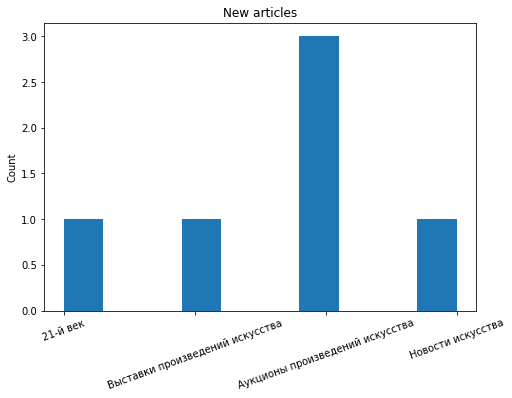


New articles titles (sience previous parsing date):

Открыт 107-й аукцион «21-й век. Современное российское искусство»
Эрмитаж потребовал досрочно вернуть работы, участвующие в итальянских выставках
Итоги AI аукциона № 420
Золотой флорин XIV века с леопардом продан на аукционе в Англии за $228 885
Первая кубистическая скульптура Пикассо из Метрополитен-музея оценочной стоимостью $30 млн будет продана на аукционе в Нью-Йорке
Объявлен шорт-лист X Премии The Art Newspaper Russia

/theartnewspaper_long_text.csv

Articles counting



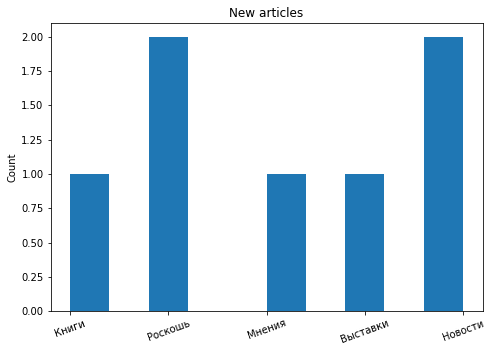


New articles titles (sience previous parsing date):

Из кого же, из кого же сделана наша эпоха: художественная панорама в лицах
Ароматы сияния
Чувствуя легкость душой и телом
Чужой гений. Андрей Ерофеев об Олеге Целкове
Современные сказки рассказывают в фешенебельном небоскребе
Поездка эрмитажного Рафаэля на выставку в Лондон отменена
В Лондоне нашли римскую мозаику, самую крупную за последние полвека


In [ ]:
for name, df in combo_df_dict.items():
  print('')
  print(name)
  print('')
  get_articles_graphic(df) # 16. Articles counting

### unify

Checking responses status & Parsing date



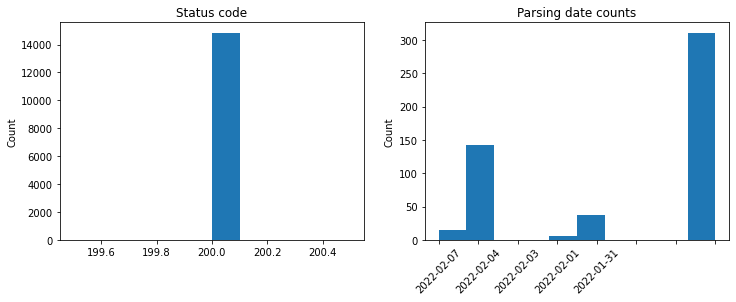

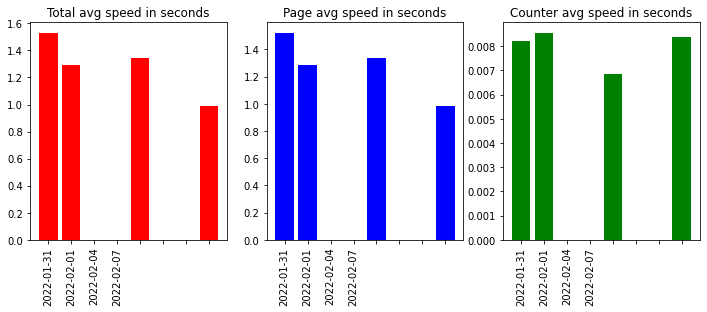

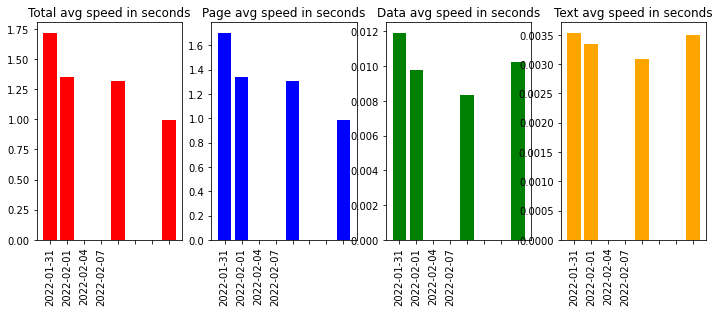

In [ ]:
# unify
get_stat_graphics() # 15. Stat graphics

## df info

In [138]:
# new info
for key, value in df_dict.items():
  for v in value:
    print(v)
    print('')
    try:
      df = open_file_csv(v, 'live') # 2. Open file.csv
      df.info()
    except:
      continue
    finally:
      print('')

-


/theartnewspaper_data_new.csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1013 entries, 0 to 1012
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               1013 non-null   object 
 1   link               1013 non-null   object 
 2   title              1013 non-null   object 
 3   short_text         1013 non-null   object 
 4   page_url           1013 non-null   object 
 5   page_title         1013 non-null   object 
 6   long_text_url      1013 non-null   object 
 7   parsing_date       1013 non-null   object 
 8   parsing_time       1013 non-null   object 
 9   parsing_sec_speed  1013 non-null   float64
dtypes: float64(1), object(9)
memory usage: 79.3+ KB

/theartnewspaper_long_text.csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1013 entries, 0 to 1012
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               -------------- 

In [ ]:
# previouse info
for key, value in df_dict.items():
  for v in value:
    print(v)
    print('')
    try:
      df = open_file_csv(v, 'live') # 2. Open file.csv
      df.info()
    except:
      continue
    finally:
      print('')

-


/theartnewspaper_data_new.csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               974 non-null    object 
 1   link               974 non-null    object 
 2   title              974 non-null    object 
 3   short_text         974 non-null    object 
 4   page_url           974 non-null    object 
 5   page_title         974 non-null    object 
 6   long_text_url      974 non-null    object 
 7   parsing_date       974 non-null    object 
 8   parsing_time       974 non-null    object 
 9   parsing_sec_speed  974 non-null    float64
dtypes: float64(1), object(9)
memory usage: 76.2+ KB

/theartnewspaper_long_text.csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ---

## artinvestment.ru

In [48]:
for line in artinvest_long_text_df['structure'].sample(10):
  for el in line[2:-2].split("', '"):
    print(el)

\n                                                        Бутылка от Дэмиена Херста\nARTinvestment.RU\xa0\xa0\xa025 октября 2011\n
скейтборды  собственного дизайна
обложку диска популярной музыкальной  группы
создал нашумевшую татуировку для  дебютного номера нового журнала Даши Жуковой «Гараж»
theartnewspaper.com
artinvestment.ru
Источник:
\n                                                        Show and tell. Художник и его модель\nARTinvestment.RU\xa0\xa0\xa010 сентября 2009\n
Юрия Альберта
Андрея Филиппова
Александра Родченко
Интервью с Юрием Альбертом
Владимир Левашов:
Юрий Альберт:
В. Л.
Вадим Захаров
Андрей Монастырский
А.\xa0Ю.
В.\xa0Л.
Ю.\xa0А.
В.\xa0Л.
«Мухоморы»
Ю.\xa0А.
В.\xa0Л.
Ю.\xa0А.
В.\xa0Л.
Ю.\xa0А.
В.\xa0Л.
Ю.\xa0А.
В.\xa0Л.
Осмоловским
Ю.\xa0А.
В.\xa0Л.
Ю.\xa0А.
В.\xa0Л.
Ю.\xa0А.
Интервью с Андреем Филипповым
Владимир Левашов
Андрей Филиппов
В.\xa0Л.
А.\xa0Ф.
В.\xa0Л.
А.\xa0Ф.
В.\xa0Л.:
А.\xa0Ф.
В.\xa0Л.
А.\xa0Ф.
В.\xa0Л.
А.\xa0Ф.
В.\xa0Л.
А.\xa0Ф.
В.\xa0Л.
А.\xa0Ф

In [46]:
for line in artinvest_long_text_df['long_text'].sample(10):
  for el in line[2:-2].split("', '"):
    print(el)

\n                                                        В венской галерее Бельведер проходит выставка Эгона Шиле\nARTinvestment.RU\xa0\xa0\xa016 мая 2011\n
Бельведер, Вена, 17\xa0февраля\xa0— 13\xa0июня 2011
В последнее время AI часто писал об Эгоне Шиле (1890–1981)\xa0— большей частью в  связи с реституционными спорами вокруг коллекции Рудольфа Леопольда. И пока Музей  Леопольда, возглавляемый сыном покойного коллекционера, Дитардом, договаривается  с наследниками прежних владельцев и время от времени работы Шиле продает (подробнее  читайте здесь, здесь и здесь), другой  ведущий музей Вены\xa0— галерея Бельведер\xa0— организует масштабную выставку,  посвященную портретам и автопортретам знаменитого художника.
Шиле начинал писать в академической манере и совсем не сразу пришел к революционному  портрету, изменившему традиционное представление об этом жанре. В своих работах  художник пытался передать эмоциональное состояние модели так, как это делали  представители раннего австрийског

## theartnewspaper.ru

In [45]:
for line in theartnewspaper_long_text_df['structure'].sample(10):
  for el in line[2:-2].split("', '"):
    print(el)

«Древо жизни» Эрнста Неизвестного стало топ-лотом торгов Artvellum
На аукцион выставлено 30 лотов — работы нонконформистов, представителей соц-арта и московского концептуализма. Топ-лотом обещает стать картина Эрнста Неизвестного «Древо жизни» из цикла «Странные рождения», написанная в Нью-Йорке в 1986 году
Токены начинают и выигрывают
На арт-рынке бум продаж цифровых произведений в формате NFT. По сути, коллекционеры продают друг другу сертификаты подлинности в крипте
Удвоение прошлого в воспоминаниях художника Михаила Чернышова о московских 1960-х
Спустя три с лишним десятилетия переизданы мемуары одного из первопроходцев геометрической абстракции и поп-арта в послевоенном СССР. О первых шагах на поприще неофициального искусства Чернышов поведал, находясь уже в эмиграции за океаном
Урал простирает объятия
Открылась 6-я Уральская индустриальная биеннале современного искусства — с эпицентром в Екатеринбурге и событиями в других городах региона
Запись 1-я. Основной проект. Обнимитесь, м

In [43]:
for line in theartnewspaper_long_text_df['long_text'].sample(10):
  for el in line[2:-2].split("', '"):
    print(el)

\nВо славу Бэнкси и уличных художников\n
\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nВ прокат выходит фильм «Бэнкси. Расцвет нелегального искусства» — подробный рассказ о том, как безвестный бристольский граффитист стал всемирно знаменитым художником\n\nОльга Кабанова\n\n18.08.2020\n
\n\nДокументальный фильм Элио Эскана «Бэнкси» с подзаголовком «Расцвет нелегального искусства» не раскроет тайны, и не надейтесь. Настоящего имени художника зрителям не назовут и лица его не покажут. Лишь мелькнет на фотографиях человек в капюшоне, но все, кому интересен Бэнкси, их уже видели. Да и вообще, вопрос, кто этот человек, подписывающийся знаменитым псевдонимом, и каков он внешне, интригует так давно, что ответ на него искать надоело.Зато фильм подробно объясняет, что за художник Бэнкси, как начинал, что в разные годы делал, почему стал знаменитым и как избегает становиться частью мировой арт-индустрии. Старомодно выражаясь, этот фильм — творческая биография художника. Которого режиссер и уважает, и обожа

## artchive.ru

In [117]:
new_lt_df = artchive_long_text_df['structure'].sample(10).copy()

In [129]:
new_lt_df[1676]

"['Семнадцать шедевров от Рубенса до Тинторетто, похищенных в Вероне, нашли под Одессой', 'Городского Музея Кастельвеккьо', 'Госпогранслужбы Украины', 'Напомним, что кража произошла', '', 'Читать дальше\\\\n', 'читаем в\\\\xa0материале Артхива', 'Александр Ройтбурд', 'странице в\\\\xa0фейсбук', 'блога ']"

In [130]:
def del_text(cell):
  l='Читать дальше\\\\n'
  new_cell = cell[2:-2].split("', '")
  for el in new_cell:
    if el==l:
      new_cell.remove(el)
  return new_cell

In [131]:
artchive_long_text_df['structure_new'] = artchive_long_text_df['structure'].apply(lambda x: del_text(x))

In [132]:
l='Читать дальше\\\\n'
for line in artchive_long_text_df['structure_new']:
  for el in line:
    if el==l:
      print(el)

In [134]:
for line in artchive_long_text_df['structure_new'].sample(10):
  for el in line:
    print(el)

«Сны наяву»: символизм Павла Кузнецова в Третьяковке
Третьяковской галереи
выставка Павла Кузнецова
«…С наступлением удивительной осени много хочет душа, стремление ввысь все сильнее и\\xa0сильнее. Я\\xa0дошел до\\xa0бреда от\\xa0красоты… Живу в\\xa0золоте и\\xa0серебре красок настроения…»\\nИз\\xa0письма Павла Кузнецова своему учителю В.А. Серову
«В\\xa0плеяде изумительных он\\xa0был самым изумительным. Кузнецов был мечтателем, его друзья были забавниками. Он\\xa0видел, они сочиняли. Он\\xa0смотрел внутрь, они наружу» Анатолий Эфрос 
Павла Кузнецова
Государственный Русский музей
Государственный Саратовский художественный музей им.\\xa0А.Н. Радищева
ксилографию
Поиски Винсента. Стиль и техника Ван Гога
Эмоции и движение
картины и\\xa0рисунки Ван Гога
Ирисы
Цветущий миндаль
Красные виноградники в\\xa0Арле
Ирисы в\\xa0вазе
Первая палитра
рисунков
Полем Гогеном
Эксперименты с палитрой и мазками
Звездной ночи
Экономия должна быть креативной
пшеничные поля
яркое солнце
звездное небо
цветущи

In [60]:
def remove_duplicates(cell):
  new_cell = []
  for el in cell[2:-2].split("', '"):
    if el not in new_cell:
      new_cell.append(el)
  return new_cell

In [61]:
artchive_long_text_df['structure_new'] = artchive_long_text_df['structure'].apply(lambda x: remove_duplicates(x))

In [135]:
artchive_long_text_df['structure'] = artchive_long_text_df['structure_new']

In [136]:
artchive_long_text_df = artchive_long_text_df.drop(['structure_new'], axis=1)
artchive_long_text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4037 entries, 0 to 4036
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   long_text_url        4037 non-null   object
 1   long_text            4037 non-null   object
 2   structure            4037 non-null   object
 3   images               4037 non-null   object
 4   sourses              4037 non-null   object
 5   tags                 4037 non-null   object
 6   parsing_sec_speed_2  4037 non-null   object
dtypes: object(7)
memory usage: 220.9+ KB


In [137]:
save_df_file(artchive_long_text_df, artchive_lt, 'test')

In [138]:
artchive_long_text_df = open_file_csv(artchive_lt, 'test')

In [140]:
for line in artchive_long_text_df['structure'].sample(10):
  for el in line[2:-2].split("', '"):
    print(el)

Кто такой Ждун и как он поселился на знаменитых картинах
а\\\\xa0своей странице в\\\\xa0Facebook
Купчиха за\\\\xa0чаем
Алёнушка
Девочка с\\\\xa0персиками
Ходоки у\\\\xa0Ленина
Неизвестная»
Опять двойка
Боярыня Морозова
Витязь на\\\\xa0распутье
Даная
Сын человеческий
Мона Лиза
Сотворение Адама
margrietvanbreevoort.nl
История любви в картинах: Эдвард Мунк и Тулла Ларсен
Эдварда Мунка
Сам\\\\xa0же Мунк от\\\\xa0разрыва и, по\\\\xa0большей части, от\\\\xa0эпизода со\\\\xa0стрельбой вылечивался долго.
Перед грозой
Фрица Таулова
Леона Бонна
Ночь в\\\\xa0Ницце
Автопортрет с\\\\xa0сигаретой
Больно будет
Рафаэля
Палец Мунка
После выстрела
воссоединенный на\\\\xa0выставке в\\\\xa0Британском музее
Уроке доктора Тульпа
Туллу-убийцу
мертвым Маратом
"Перманентная революция". Современное украинское искусство представляют в Музее Людвига в Будапеште
Статья названа символично: «Искусство Украины в\\\\xa0эпоху четырёх революций».
Влады Ралко
Игоря Гусева
Телеграме
Инстаграме
Штрихи к портрету. Как Васил

In [42]:
for line in artchive_long_text_df['long_text'].sample(10):
  #print(line)
  for el in line[2:-2].split("', '"):
    print(el)

В Милане представляют крупную выставку работ Маурица Корнелиса Эшера
Мауриц Корнелис Эшер (1898\xa0— 1972) оставил после себя обширное наследие, которое не\xa0только не\xa0устаревает со\xa0временем, но\xa0и\xa0существенно влияет на\xa0новые цифровые технологии. Палаццо Реале в\xa0Милане до\xa0конца января принимает крупную экспозицию работ художника: более 200 математически выверенных гравюр, литографий и\xa0меццо-тинто.
\n\nМауриц Корнелис Эшер известен своим вкладом как в\xa0изобразительное искусство, так и\xa0математику. На\xa0его работах часто можно увидеть сложные конструкции, исследования бесконечности и\xa0взаимосвязанные геометрические узоры, которые постепенно принимают совершенно неожиданные формы. Многие созданные им\xa0миры строятся вокруг невозможных объектов, таких как куб Неккера и\xa0треугольник Пенроуза.Слева: Мауриц Корнелис Эшер, «Автопортрет в\xa0зеркале»\n
Художник родился в\xa0Леувардене, на\xa0севере Нидерландов, в\xa0богатой семье и\xa0провёл счастливое детство,

In [141]:
save_df_file(artchive_long_text_df, artchive_lt, 'live')

## artuzel.com

In [50]:
for line in artuzel_long_text_df['structure'].sample(10):
  for el in line[2:-2].split("', '"):
    print(el)

27.05.2019
\n          В галерее ISSMAG открылась выставка Фаины Бродской        
15 мая галерея ISSMAG открылась с новой выставочной программой. Первым проектом стала соло-выставка графики нью-йоркской художницы Фаины Бродской.
05.12.2017
\n          Никита Макаров: "Если не давать зрителю возможность выбора, это станет похоже на диктат одного направления над другим..."        
Над текстом работал Юлия Крышевич
Фото предоставлены\xa0
Marfedor Bureau
\xa0
5 декабря в Московском музее современного искусства на Тверском бульваре при поддержке нью-йоркской Want Art Gallery и московской Askeri Gallery открылась выставка «Finis Terrae: на краю зачарованного мира». Пока в музее велись активные монтажные работы, мы поговорили с ее автором, художником Никитой Макаровым. Он рассказал об актуальном искусстве, почему стоит ценить время и зачем зрителю давать возможность выбора.

Юля: Никита, вы выставлялись в таких местах, как Мусейон, Artplay, Усадьба Муравьевых-Апостолов. Выставка\xa0 "Finis Te

In [49]:
for line in artuzel_long_text_df['long_text'].sample(10):
  for el in line[2:-2].split("', '"):
    print(el)

\n          События 23-29 января        
MIGRATIO
24.01.2017-5.03.2017
ММОМА (Ермолаевский, 17)
Московский музей современного искусства представляет масштабный проект-ретроспективу Валерия Айзенберга (1947 г.р.) «MIGRATIO», куратором которого выступил Леонид Бажанов. Задача выставки — показать контекст и развитие современного российского искусства за последние полвека через призму творчества одного из самых ярких российских художников, громко заявившего о себе в 1980-е годы и остающегося актуальным сегодня.
Выставка представит более 100 произведений, созданных Валерием Айзенбергом в течение последних 40 лет, но выстроит их не в свойственном ретроспекции хронологическом порядке линии жизни, а сгруппирует особым инсталляционным образом. К открытию проекта в ММОМА приурочен выход каталога, который стал результатом творческого симбиоза Валерия Айзенберга и Константина Аджера и, в отличие от экспозиции, имеет линейную структуру.

Telo
20.01.2017-29.01.2017
КЦСИ "Типография" (Краснодар)
С то